In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
pd.set_option('chained_assignment',None)

In [2]:
%run '../util/webrtc_reader.py'

In [3]:
data_path = '../../data/Data_meet_no_loss'
trace_path = '../../VCA/no_loss_traces'

In [20]:
data = []
for exp in os.listdir(data_path):
    exp_id = exp.split('_')[-1]
    trace = [x for x in os.listdir(trace_path) if x.endswith('_'+exp_id+'.csv')][0]
    trace = f'{trace_path}/{trace}'
    webrtc = os.listdir(f'{data_path}/{exp}/meet/webrtc')[0]
    annotated = f'{data_path}/{exp}/meet/rec/fps.csv'
    html5 = os.listdir(f'{data_path}/{exp}/meet/html5')[0]
    webrtc = f'{data_path}/{exp}/meet/webrtc/{webrtc}'
    html5 = f'{data_path}/{exp}/meet/html5/{html5}'
    data.append((int(exp_id), trace, webrtc, annotated, html5))

NameError: name 'trace_path' is not defined

In [150]:
def parse_html5(fname):
    with open(fname, 'rb') as fd:
        f = json.load(fd)
    k = list(f.keys())[0]
    df = pd.DataFrame(f[k])
    df['total'] = df['total'].diff().fillna(df['total'])
    df['dropped'] = df['dropped'].diff().fillna(df['dropped'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].apply(lambda x: int(x.timestamp()) + 1)
    df = df.rename(columns={'total': 'fps_total', 'dropped': 'fps_html_dropped', 'timestamp': 'html_ts'})
    df['fps_html_rendered'] = df['fps_total'] - df['fps_html_dropped']
    return df[['fps_html_rendered', 'fps_html_dropped', 'html_ts']]

def parse_webrtc(fname):
    reader = WebRTCReader(fname)
    df = reader.get_webrtc()
    df['ts'] += 1
    dw = df.rename(columns={'ts': 'webrtc_ts', 'framesDecodedPerSecond': 'fps_webrtc', '[bytesReceived_in_bits/s]': 'bitrate'})
    dw['bitrate'] = dw['bitrate']/1000
    return [['webrtc_ts', 'fps_webrtc', 'bitrate']]

def parse_annotated(fname):
    df = pd.read_csv(fname, index_col=None)
    df = df.drop(['Unnamed: 0'], axis=1)
    df['timestamp'] = df['timestamp'].astype(int)
    df = df.rename(columns={'fps': 'fps_annotated', 'timestamp': 'annotated_ts'})
    return df

def extract_qos(trace):
    bname = os.path.basename(trace)
    qos = bname.split('.')[0].split('_')
    return map(int, qos[:4])

def get_trace_info(trace):
    df = pd.read_csv(trace, header=None, names=['throughput', 'latency', 'loss'])
    return df

def plot_trace(trace):
    df = get_trace_info(trace)
    f, a = plt.subplots(2, 1, figsize=(20, 6))
    a[0].plot(list(range(len(df))), df['throughput'], 'o-')
    a[0].set_ylabel('Throughput')
    a[0].set_xlabel('Relative time')
    a[0].grid(visible=1)
    a[1].plot(list(range(len(df))), df['latency'], 'o-')
    a[1].set_ylabel('Latency')
    a[1].set_xlabel('Relative time')
    a[1].grid(visible=1)
    plt.show()
    
def combine(data):
    dfs = []
    for call in data:
        call_id = call[0]
        df_webrtc = parse_webrtc(call[2])
        df_anno = parse_annotated(call[3])
        df_html = parse_html5(call[4])
        trace = call[1]
        df = pd.merge(df_html, df_anno, how='left', left_on='html_ts', right_on='annotated_ts')
        df = pd.merge(df, df_webrtc, how='left', left_on='html_ts', right_on='webrtc_ts')
        df['call_id'] = call_id
        df['trace'] = trace
        df['throughput'], df['throughput_jitter'], df['latency'], df['latency_jitter'] = zip(*df['trace'].map(extract_qos))
        df_trace = get_trace_info(trace)
        df['mean_throughput'] = df_trace['throughput'].mean()
        df['std_throughput'] = df_trace['throughput'].std()
        df['mean_latency'] = df_trace['latency'].mean()
        df['std_latency'] = df_trace['latency'].std()
        dfs.append(df)
    return pd.concat(dfs, axis=0)

def diagnose(df, call_id):
    df1 = df[df['call_id'] == call_id]
    df1['relative_time'] = df1['html_ts'] - df1['html_ts'].min()
    fig, ax = plt.subplots(3, 1, figsize=(20, 12))
    print(df1['trace'].unique())
    df1[['fps_webrtc', 'relative_time']].plot(x='relative_time', y='fps_webrtc', style='o-', ax=ax[0])
    df1[['fps_annotated', 'relative_time']].plot(x='relative_time', y='fps_annotated', style='o-', ax=ax[0])
    df1[['fps_html_rendered', 'relative_time']].plot(x='relative_time', y='fps_html_rendered', style='o-', ax=ax[0])
    ax[0].set_xlabel('Relative time')
    ax[0].set_ylabel('Frames rendered/decoded')
    ax[0].grid(visible=1)
    ax[0].set_xlim([-1, 60])
    trace = df1['trace'].unique()[0]
    tdf = get_trace_info(trace)
    ax[1].plot(list(range(len(tdf))), tdf['throughput'], 'o-')
    ax[1].set_ylabel('Throughput')
    ax[1].set_xlabel('Relative time')
    ax[1].grid(visible=1)
    ax[1].set_xlim([-1, 60])
    ax[2].plot(list(range(len(tdf))), tdf['latency'], 'o-')
    ax[2].set_ylabel('Latency')
    ax[2].set_xlabel('Relative time')
    ax[2].grid(visible=1)
    ax[2].set_xlim([-1, 60])
    
def rendered_vs_dropped(df, call_id):
    df1 = df[df['call_id'] == call_id]
    df1['relative_time'] = df1['html_ts'] - df1['html_ts'].min()
    fig, ax = plt.subplots(figsize=(20, 4))
    print(df1['trace'].unique())
    df1[['fps_html_rendered', 'relative_time']].plot(x='relative_time', y='fps_html_rendered', style='o-', ax=ax)
    df1[['fps_html_dropped', 'relative_time']].plot(x='relative_time', y='fps_html_dropped', style='o-', ax=ax)
    ax.set_xlabel('Relative time')
    ax.set_ylabel('Number of frames')
    ax.grid(visible=1)
    plt.show()

In [65]:
data = sorted(data, key=lambda x: x[0])

In [66]:
df = combine(data)
df

KeyError: "['Unnamed: 0'] not found in axis"

**Description of Traces**

throughput = [1000, 2000, 10000] kbps

th_jitter = [0, 250, 500, 1000] kbps

latency = [1, 10, 100, 200] ms

lat_jitter = [0, 10, 30, 50] ms

loss = [0] %

For the 42 traces used in this analysis, the average throughput was fixed to 1 Mbps. No data from latency = 100 ms and latency jitter = 10 ms onwards.

**Questions of interest**

1. In what cases does webrtc report less number of FPS values than the call duration in seconds?
2. What does the time-series plot of different types of FPS look like for a call?
3. What happens to each type of FPS in different throughput and latency profiles?
4. Under what conditions are frames dropped?

In [8]:
call_dict = {'call_number': [], 'num_webrtc_values': [], 'num_html_values': [], 'num_anno_values': []}
for call_id in df['call_id'].unique():
    dfc = df[df['call_id'] == call_id]
    call_dict['call_number'] += [call_id]
    call_dict['num_webrtc_values'] += [len(dfc[~dfc['fps_webrtc'].isna()])]
    call_dict['num_anno_values'] += [len(dfc[~dfc['fps_annotated'].isna()])]
    call_dict['num_html_values'] += [len(dfc['fps_html_rendered'])]
vcdf = pd.DataFrame(call_dict)

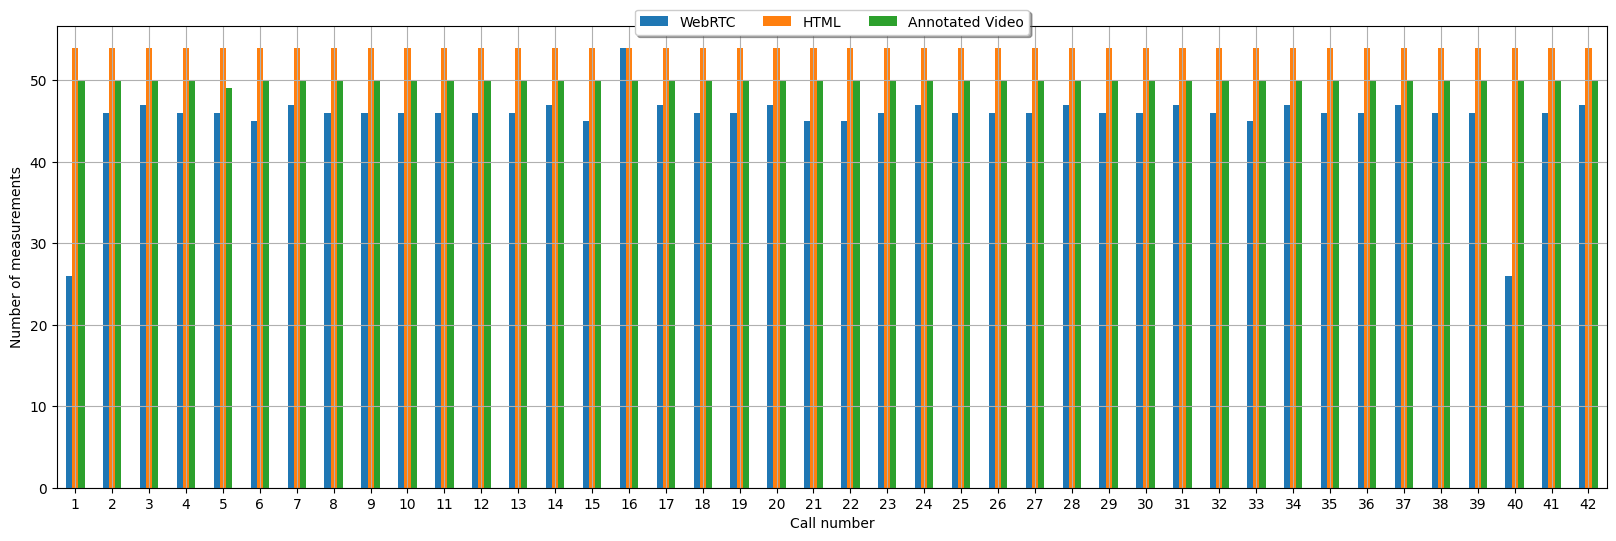

In [9]:
vcdf = vcdf.sort_values(by='call_number')
vcdf.plot.bar(x='call_number', rot=0, figsize=(20, 6))
plt.grid(visible=1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True, labels=['WebRTC', 'HTML', 'Annotated Video'])
plt.ylabel('Number of measurements')
plt.xlabel('Call number')
plt.savefig('../analysis/plots/Data_meet_no_loss/measurement_count.png', dpi=300)

['../../VCA/no_loss_traces/1000_0_10_50_0_8.csv']


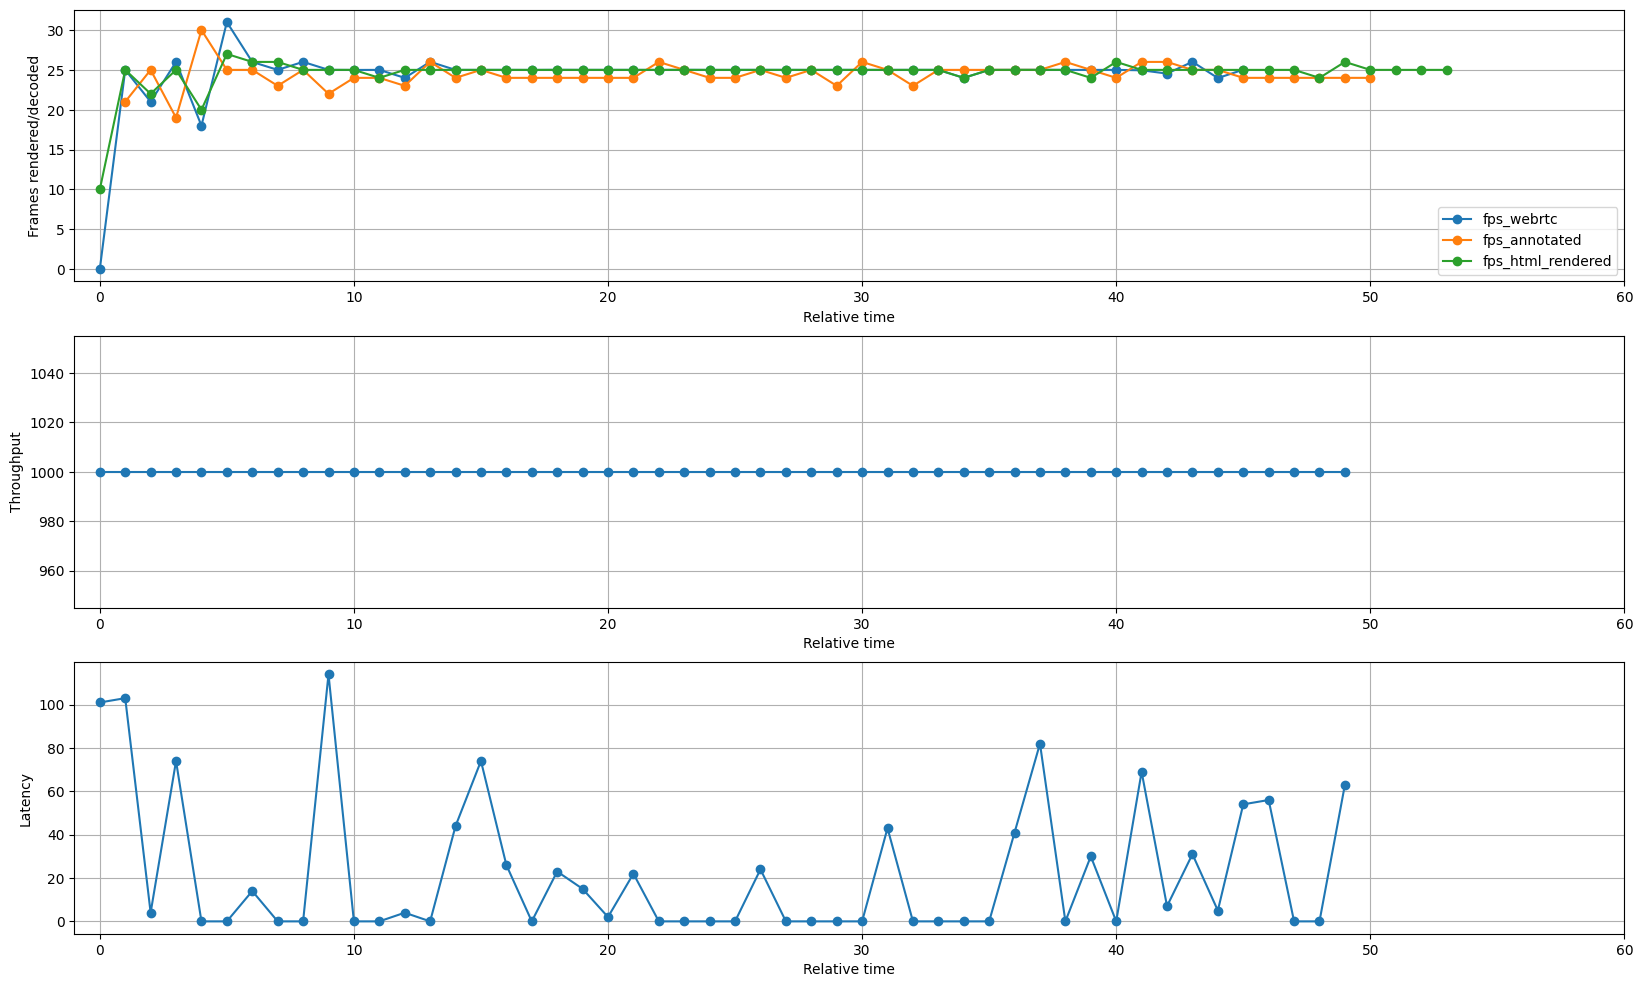

In [24]:
diagnose(df, 8)

In [11]:
parse_webrtc(data[0][2])

,webrtc_ts,fps_webrtc
0,1679607381,0.000000
1,1679607382,23.003867
2,1679607383,20.499096
3,1679607384,22.000037
4,1679607385,26.001609
5,1679607386,24.999377
6,1679607387,24.999824
7,1679607388,24.995712
8,1679607389,25.003875
9,1679607390,24.001225


['../../VCA/no_loss_traces/1000_0_10_0_0_5.csv']


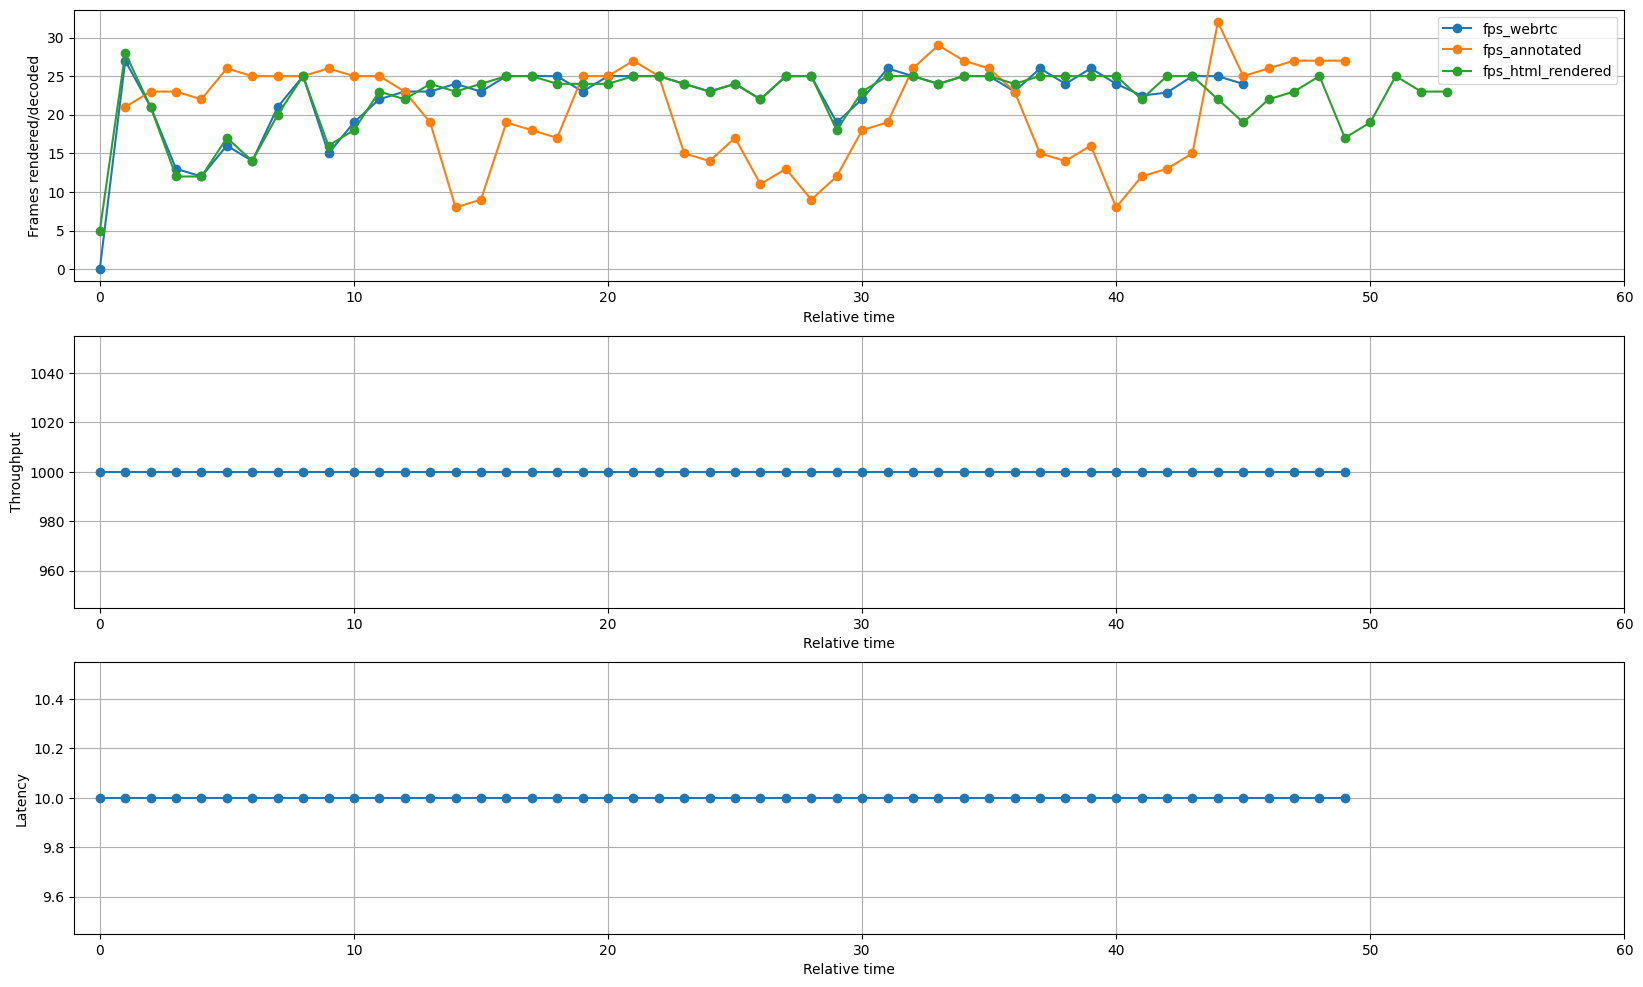

In [22]:
diagnose(df, 5)

In [13]:
dfw = parse_webrtc(data[39][2])
print('WebRTC:', dfw['webrtc_ts'].min(), dfw['webrtc_ts'].max())
print('HTML:', df[df['call_id'] == 40]['html_ts'].min(), df[df['call_id'] == 40]['html_ts'].max())

WebRTC: 1679613871 1679613896
HTML: 1679613871 1679613924


['../../VCA/no_loss_traces/1000_0_1_0_0_1.csv']


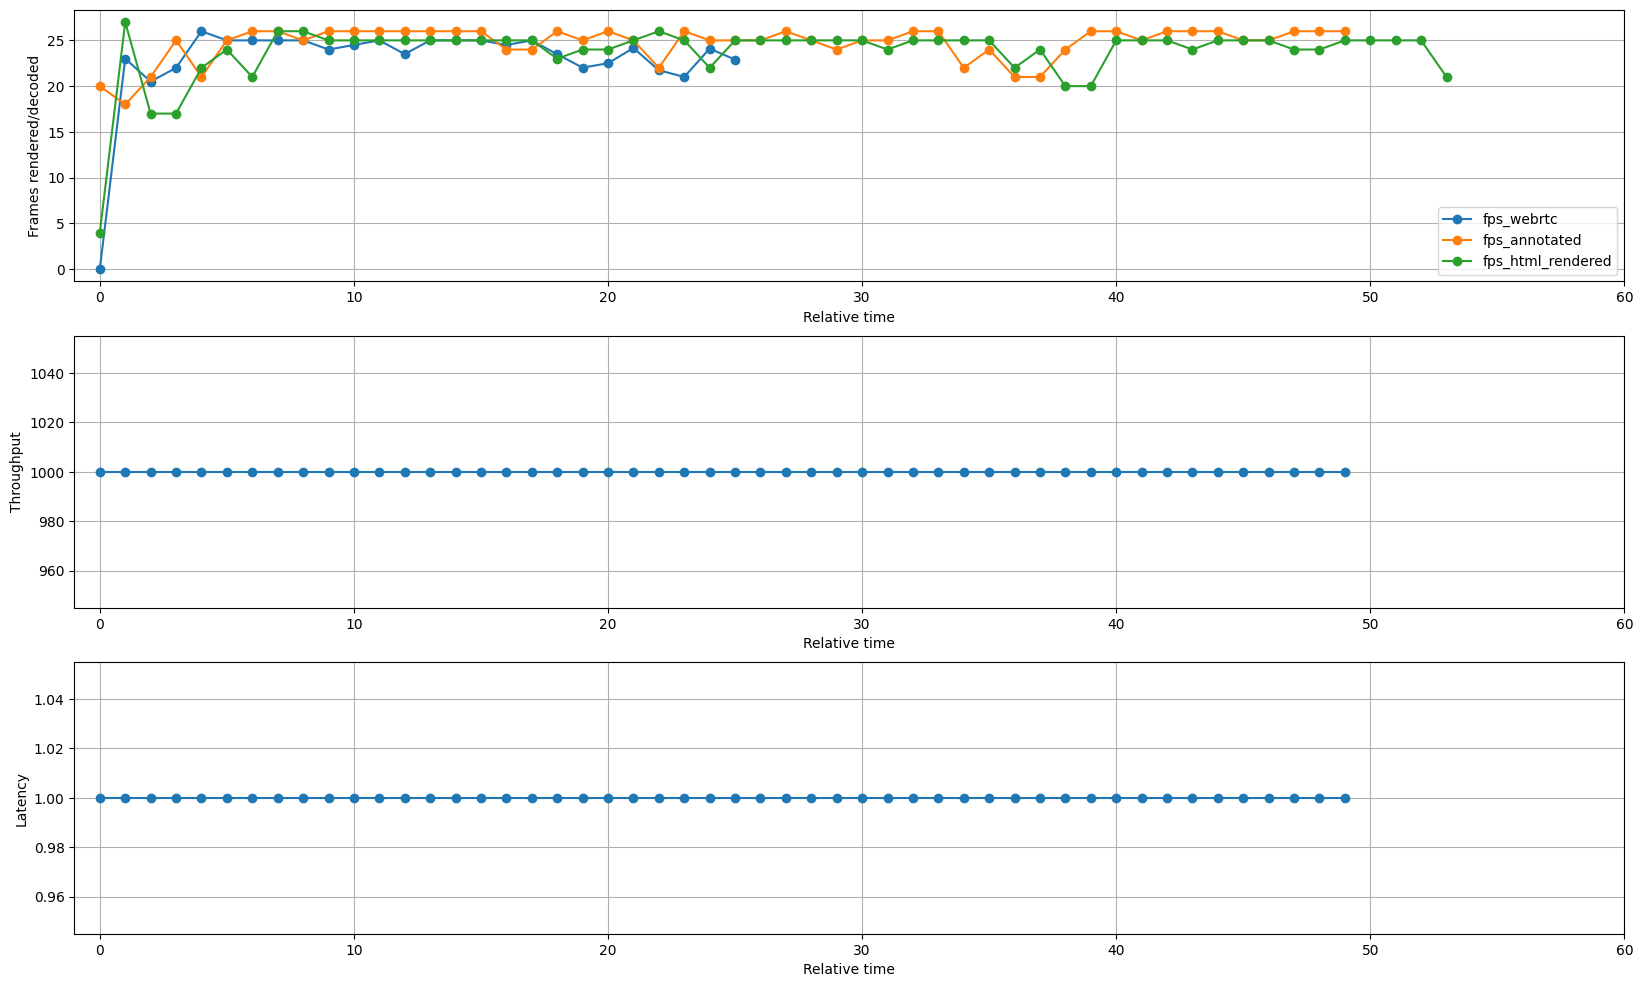

In [14]:
diagnose(df, 1)

In [15]:
df_fps = df.groupby('call_id')['fps_html_rendered'].std().reset_index()
df_tj = df.groupby('call_id')['std_throughput'].mean().reset_index()
df_lj = df.groupby('call_id')['std_latency'].mean().reset_index()
df_t = df.groupby('call_id')['mean_throughput'].mean().reset_index()
df_l = df.groupby('call_id')['mean_latency'].mean().reset_index()
df_ft = pd.merge(df_fps, df_tj, on='call_id')
df_ftl = pd.merge(df_ft, df_lj, on='call_id')
df_ftl = pd.merge(df_ftl, df_t, on='call_id')
df_ftl = pd.merge(df_ftl, df_l, on='call_id')

In [16]:
df_ftl[df_ftl['fps_html_rendered'] > 4]

,call_id,fps_html_rendered,std_throughput,std_latency,mean_throughput,mean_latency
3,4,4.427260,0.000000,25.744934,1000.00,20.12
4,5,4.216204,0.000000,0.000000,1000.00,10.00
11,12,4.242641,0.000000,51.991856,1000.00,105.50
17,18,7.231545,211.866242,5.592415,967.96,4.48
21,22,6.165576,258.774821,8.719577,948.20,12.36
24,25,7.841035,278.692326,0.000000,999.34,100.00
25,26,5.567827,279.851115,10.121325,954.92,102.26
33,34,8.366454,508.301937,4.912500,1088.72,3.50
34,35,4.896268,494.533012,18.254482,988.28,14.72


['../../VCA/no_loss_traces/1000_250_100_10_0_26.csv']


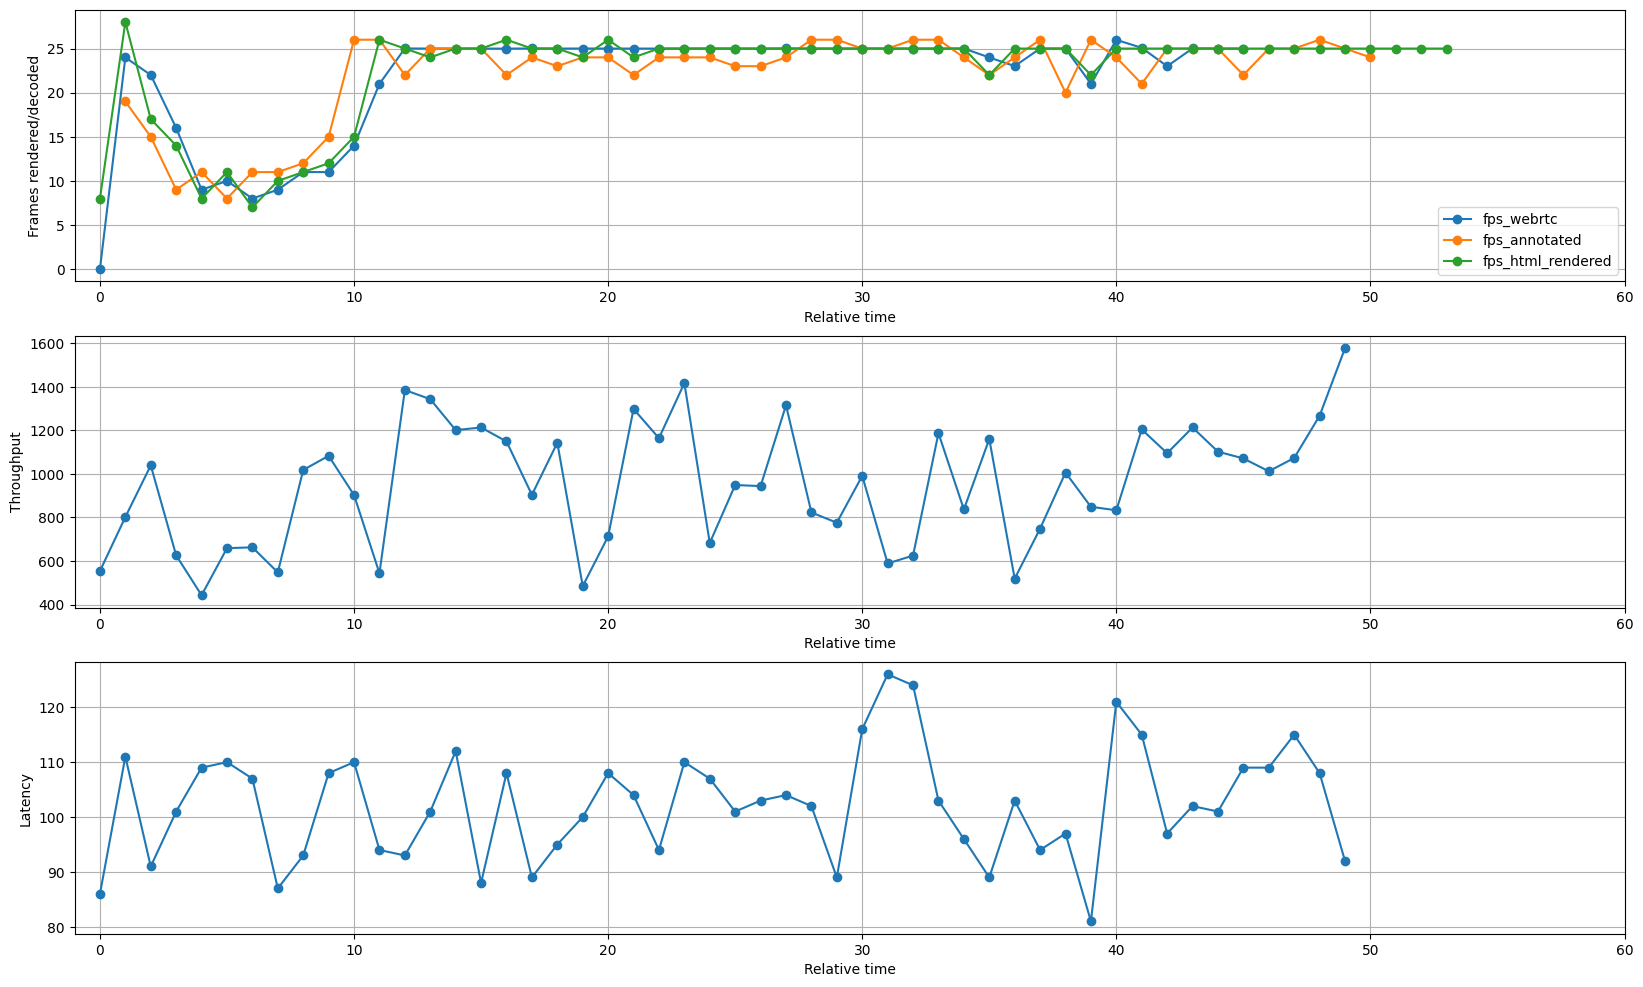

In [17]:
diagnose(df, 26)

1 - stable

2 - stable

3 - rampup phase less typical, but stable after that

4 - less stable, occasional dips

5 - unstable, late rampup (10 ms constant latency)

6 - stable

7 - stable

8 - stable

9 - stable

10 - stable

11 - stable

12 - rampup phase less typical, but stable after that

13 - surprisingly stable (200 ms constant latency)

14 - stable

15 - stable

16 - stable

17 - 2 dips around 30 sec, reason unknown. maybe high throughput jitter?

18 - stable with a peculiar rampup

19 - rampup starts to destabilize towards the end

20 - stable

21 - stable

22 - rampup phase less typical, but stable after that

23 - stable

24 - mostly stable

25 - a dip after rampup, stable after that

26 - slow rampup, then stable

27 - rampup destabilizes towards the end

28 - stable

29 - mostly stable

30 - stable

31 - stable

32 - stable

33 - unstable, dipping below 25 most of the time

34 - very unstable, rampup achieved for a short while

35 - unstable, dip towards the end

36 - stable

37 - stable

38 - mostly stable

39 - atypical rampup, but stable after that

40 - stable

41 - stable

42 - stable

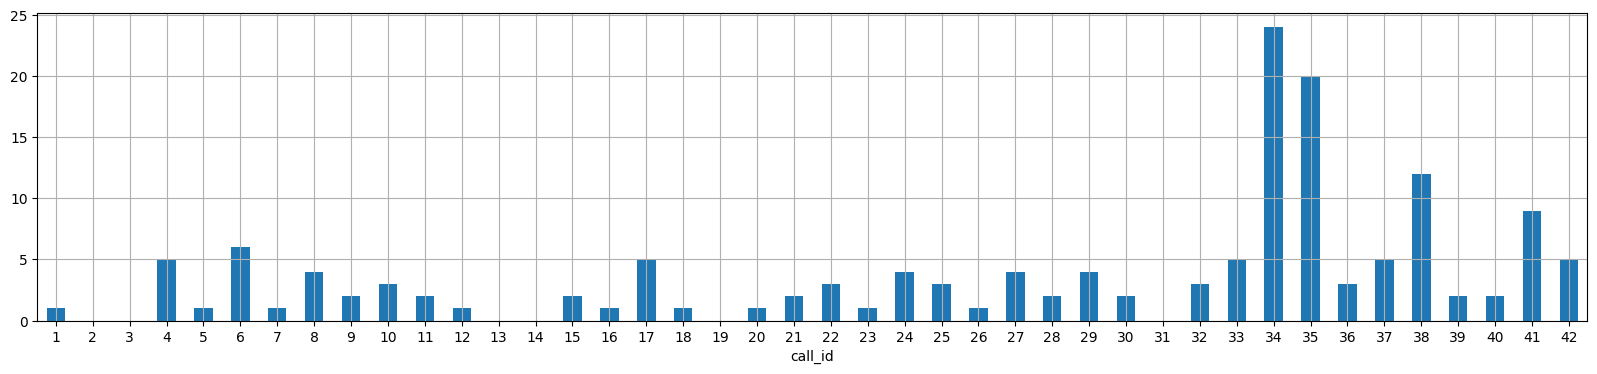

In [18]:
df.groupby('call_id')['fps_html_dropped'].sum().plot(kind='bar', rot=0, figsize=(20, 4))
plt.grid(visible=1)

['../../VCA/no_loss_traces/1000_500_1_0_0_33.csv']


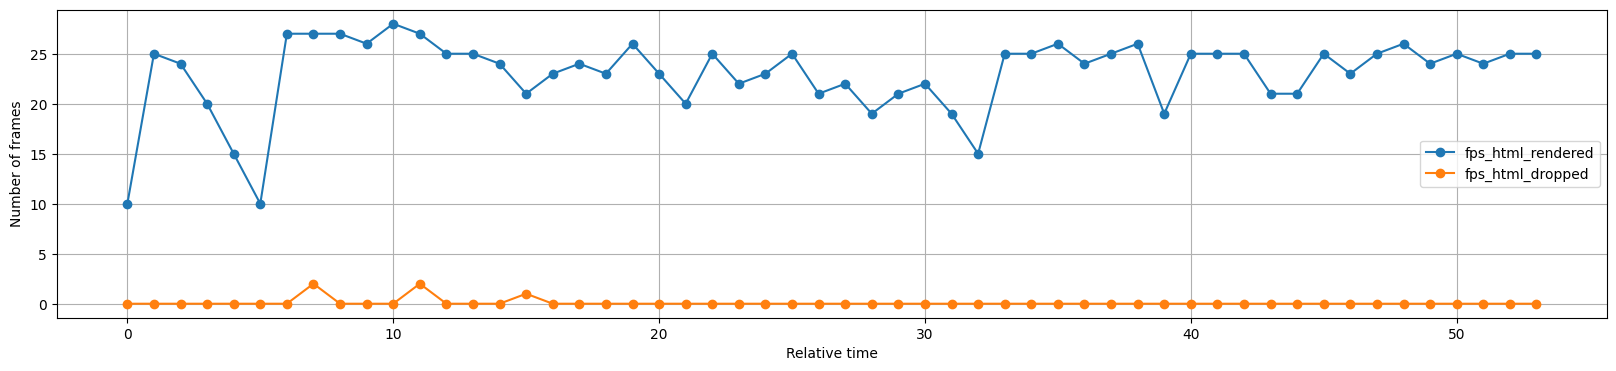

In [19]:
rendered_vs_dropped(df, 33)

## With or without recording

In [168]:
data_path = '../../data/Data_w_wo_rec'

In [169]:
data = []
for exp in os.listdir(data_path):
    for rep in os.listdir(data_path+'/'+exp):
        p = f'{data_path}/{exp}/{rep}'
        webrtc = os.listdir(f'{p}/meet/webrtc')[0]
        html5 = os.listdir(f'{p}/meet/html5')[0]
        webrtc = f'{p}/meet/webrtc/{webrtc}'
        html5 = f'{p}/meet/html5/{html5}'
        data.append((exp, rep, webrtc, html5))

In [170]:
len(data)

10

In [18]:
def parse_html5(fname):
    with open(fname, 'rb') as fd:
        f = json.load(fd)
    k = list(f.keys())[0]
    df = pd.DataFrame(f[k])
    df['total'] = df['total'].diff().fillna(df['total'])
    df['dropped'] = df['dropped'].diff().fillna(df['dropped'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].apply(lambda x: int(x.timestamp()) + 1)
    df = df.rename(columns={'total': 'fps_total', 'dropped': 'fps_html_dropped', 'timestamp': 'html_ts'})
    df['fps_html_rendered'] = df['fps_total'] - df['fps_html_dropped']
    return df[['fps_html_rendered', 'fps_html_dropped', 'html_ts']]

def parse_webrtc(fname):
    reader = WebRTCReader(fname)
    df = reader.get_webrtc()
    df['ts'] += 1
    dw = df.rename(columns={'ts': 'webrtc_ts', 'framesPerSecond': 'fps_webrtc', '[bytesReceived_in_bits/s]': 'bitrate'})
    dw['bitrate'] = dw['bitrate']/1000
    return dw[['webrtc_ts', 'fps_webrtc', 'bitrate', 'frameHeight', 'duration', 'num_vals']]
    
def combine(data):
    dfs = []
    for call in data:
        exp = call[0]
        rep = call[1]
        df_webrtc = parse_webrtc(call[2])
        df_html = parse_html5(call[3])
        df = pd.merge(df_html, df_webrtc, how='left', left_on='html_ts', right_on='webrtc_ts')
        df['exp'] = exp
        df['rep'] = rep
        dfs.append(df)
    return pd.concat(dfs, axis=0)

def diagnose(df, profiles):
    for profile in profiles:
        df1 = df[df['exp'] == profile]
        dfs1 = []
        for rep in df1['rep'].unique():
            dfr = df1[df1['rep'] == rep]
            dfr['relative_time'] = dfr['html_ts'] - dfr['html_ts'].min()
            dfs1.append(dfr)
        d1 = pd.concat(dfs1)
        fig, ax = plt.subplots(1, 3, figsize=(20, 4))
        ax[0].grid(visible=1)
        sns.lineplot(x = 'relative_time', y='fps_webrtc', data=d1.reset_index(), err_style='band', estimator='mean', marker='o', ax=ax[0])
        ax[0].set_ylim([0, 30])
        ax[1].grid(visible=1)
        sns.lineplot(x = 'relative_time', y='bitrate', data=d1.reset_index(), err_style='band', estimator='mean', marker='o', ax=ax[1])
        ax[1].set_ylim([0, 1500])
        ax[2].grid(visible=1)
        sns.lineplot(x = 'relative_time', y='frameHeight', data=d1.reset_index(), err_style='band', estimator='mean', marker='o', ax=ax[2])
        ax[2].set_ylim([0, 1000])
        plt.suptitle(profile)
        
def rendered_vs_dropped(df, call_id):
    df1 = df[df['call_id'] == call_id]
    df1['relative_time'] = df1['html_ts'] - df1['html_ts'].min()
    fig, ax = plt.subplots(figsize=(20, 4))
    print(df1['trace'].unique())
    df1[['fps_html_rendered', 'relative_time']].plot(x='relative_time', y='fps_html_rendered', style='o-', ax=ax)
    df1[['fps_html_dropped', 'relative_time']].plot(x='relative_time', y='fps_html_dropped', style='o-', ax=ax)
    ax.set_xlabel('Relative time')
    ax.set_ylabel('Number of frames')
    ax.grid(visible=1)
    plt.show()

In [19]:
df = combine(data)
df

125.96800017356873
125.96800017356873


KeyError: "['num_vals'] not in index"

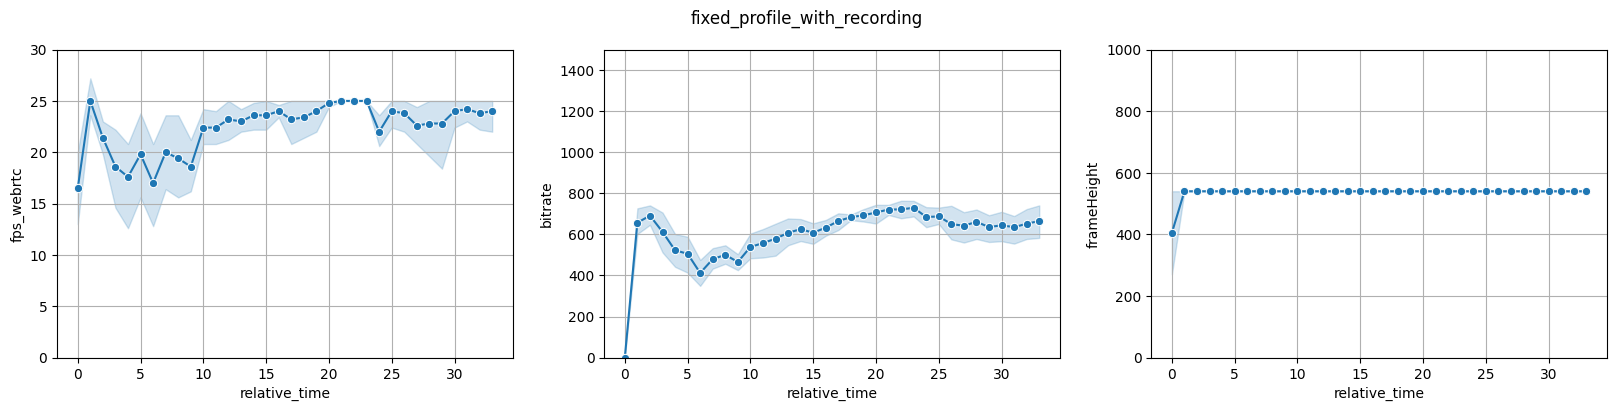

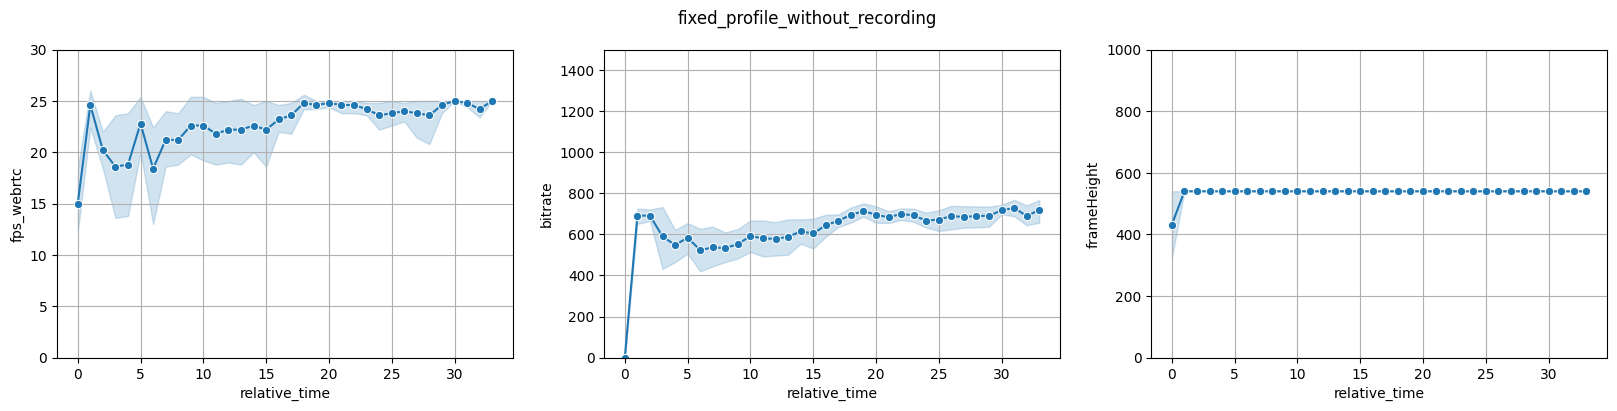

In [173]:
diagnose(df, ['fixed_profile_with_recording', 'fixed_profile_without_recording'])

In [26]:
data_path = '/data/vca-qoe-inference/model_data/data/conext_data'
data = []
for exp in os.listdir(data_path):
    for rep in os.listdir(data_path+'/'+exp):
        p = f'{data_path}/{exp}/{rep}'
        webrtc = os.listdir(f'{p}/meet/webrtc')[0]
        html5 = os.listdir(f'{p}/meet/html5')[0]
        webrtc = f'{p}/meet/webrtc/{webrtc}'
        html5 = f'{p}/meet/html5/{html5}'
        data.append((exp, rep, webrtc, html5))
df = combine(data)
df

,fps_html_rendered,fps_html_dropped,html_ts,webrtc_ts,fps_webrtc,bitrate,frameHeight,duration,num_vals,exp,rep
0,9.0,0.0,1679864980,1.679865e+09,18.0,0.000000,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2
1,25.0,0.0,1679864981,1.679865e+09,26.0,711.185927,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2
2,25.0,0.0,1679864982,1.679865e+09,25.0,795.907587,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2
3,25.0,0.0,1679864983,1.679865e+09,25.0,783.984561,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2
4,24.0,0.0,1679864984,1.679865e+09,25.0,1059.609095,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2
...,...,...,...,...,...,...,...,...,...,...,...
119,25.0,0.0,1679853266,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1
120,25.0,0.0,1679853267,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1
121,25.0,0.0,1679853268,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1
122,25.0,0.0,1679853269,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1


In [28]:
df['exp_id'] = df['exp'] + '_' + df['rep']
df

,fps_html_rendered,fps_html_dropped,html_ts,webrtc_ts,fps_webrtc,bitrate,frameHeight,duration,num_vals,exp,rep,exp_id
0,9.0,0.0,1679864980,1.679865e+09,18.0,0.000000,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2,fixed_profile_2000_0_0_rep_2
1,25.0,0.0,1679864981,1.679865e+09,26.0,711.185927,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2,fixed_profile_2000_0_0_rep_2
2,25.0,0.0,1679864982,1.679865e+09,25.0,795.907587,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2,fixed_profile_2000_0_0_rep_2
3,25.0,0.0,1679864983,1.679865e+09,25.0,783.984561,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2,fixed_profile_2000_0_0_rep_2
4,24.0,0.0,1679864984,1.679865e+09,25.0,1059.609095,540.0,125.968,47.0,fixed_profile_2000_0_0,rep_2,fixed_profile_2000_0_0_rep_2
...,...,...,...,...,...,...,...,...,...,...,...,...
119,25.0,0.0,1679853266,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1,fixed_profile_300_0_0_rep_1
120,25.0,0.0,1679853267,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1,fixed_profile_300_0_0_rep_1
121,25.0,0.0,1679853268,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1,fixed_profile_300_0_0_rep_1
122,25.0,0.0,1679853269,NaN,NaN,NaN,NaN,NaN,NaN,fixed_profile_300_0_0,rep_1,fixed_profile_300_0_0_rep_1


In [30]:
df.groupby('exp_id')[['duration', 'num_vals']].mean().reset_index()

,exp_id,duration,num_vals
0,fixed_profile_10000_0_0_rep_0,127.340,47.0
1,fixed_profile_10000_0_0_rep_1,127.600,47.0
2,fixed_profile_10000_0_0_rep_2,126.752,47.0
3,fixed_profile_10000_0_0_rep_3,126.624,46.0
4,fixed_profile_10000_0_0_rep_4,126.536,46.0
5,fixed_profile_1000_0_0_rep_0,127.296,47.0
6,fixed_profile_1000_0_0_rep_1,127.480,47.0
7,fixed_profile_1000_0_0_rep_2,127.721,48.0
8,fixed_profile_1000_0_0_rep_3,126.056,46.0
9,fixed_profile_1000_0_0_rep_4,126.888,46.0


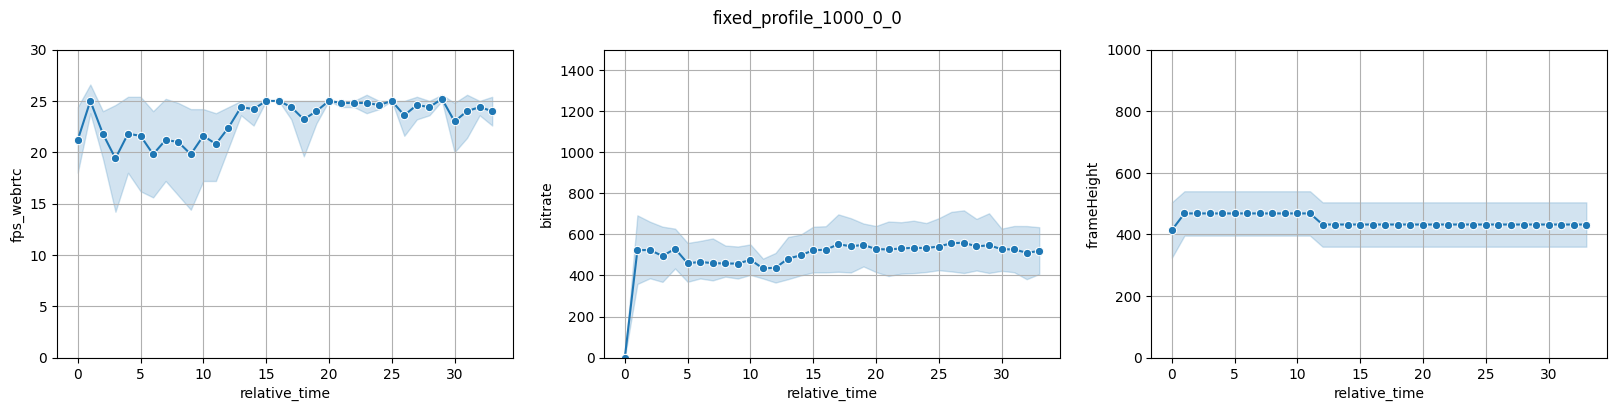

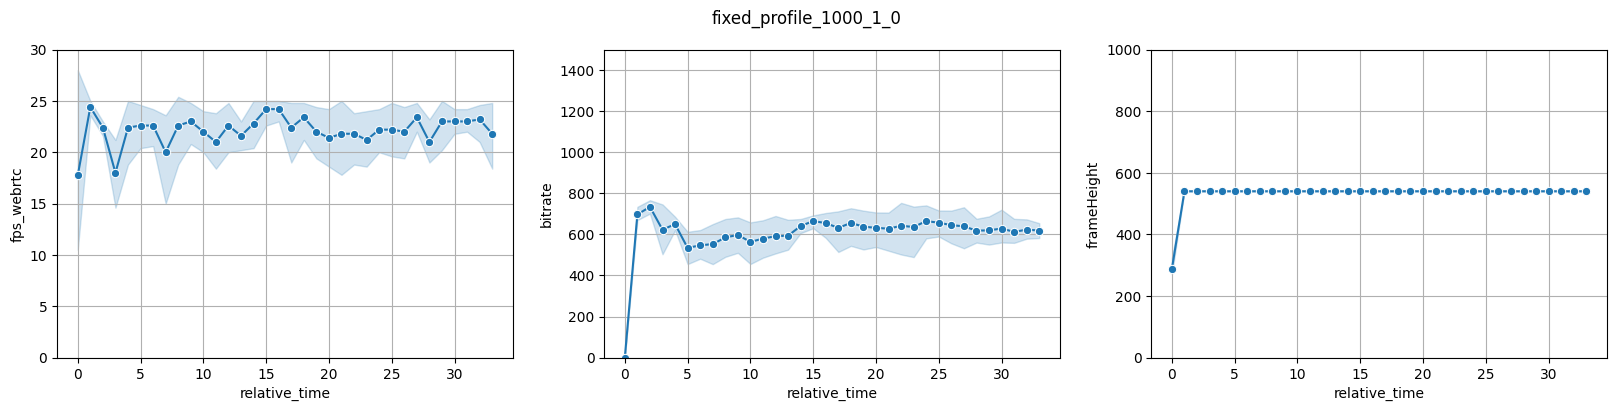

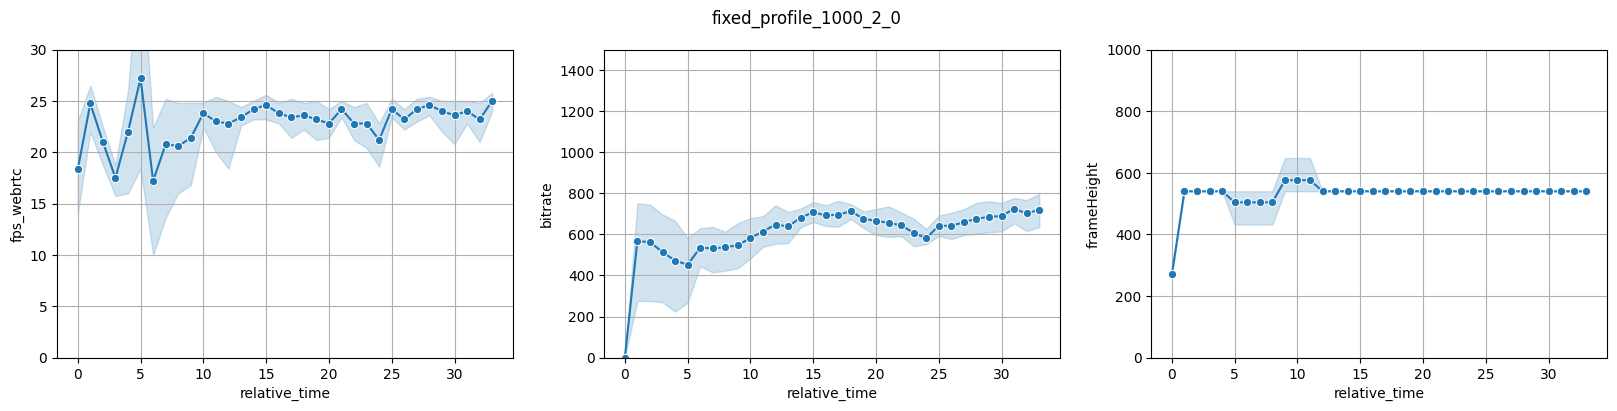

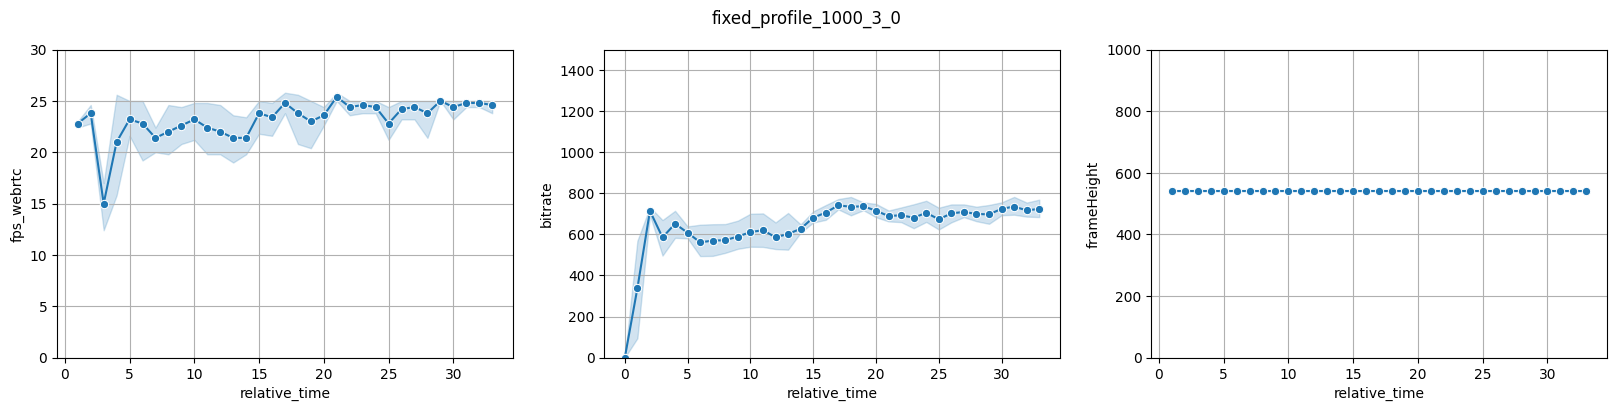

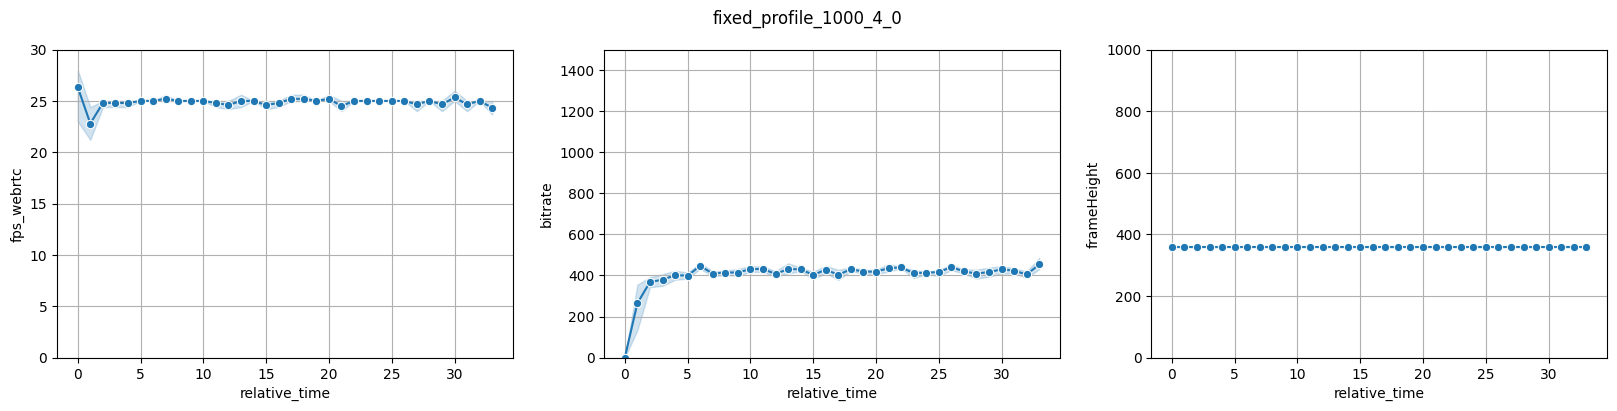

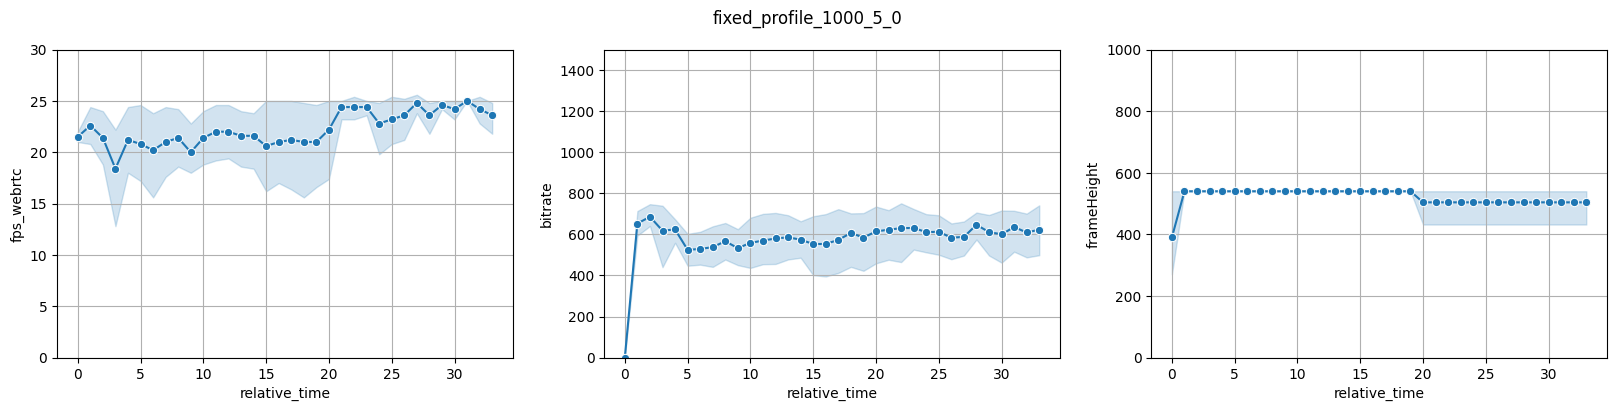

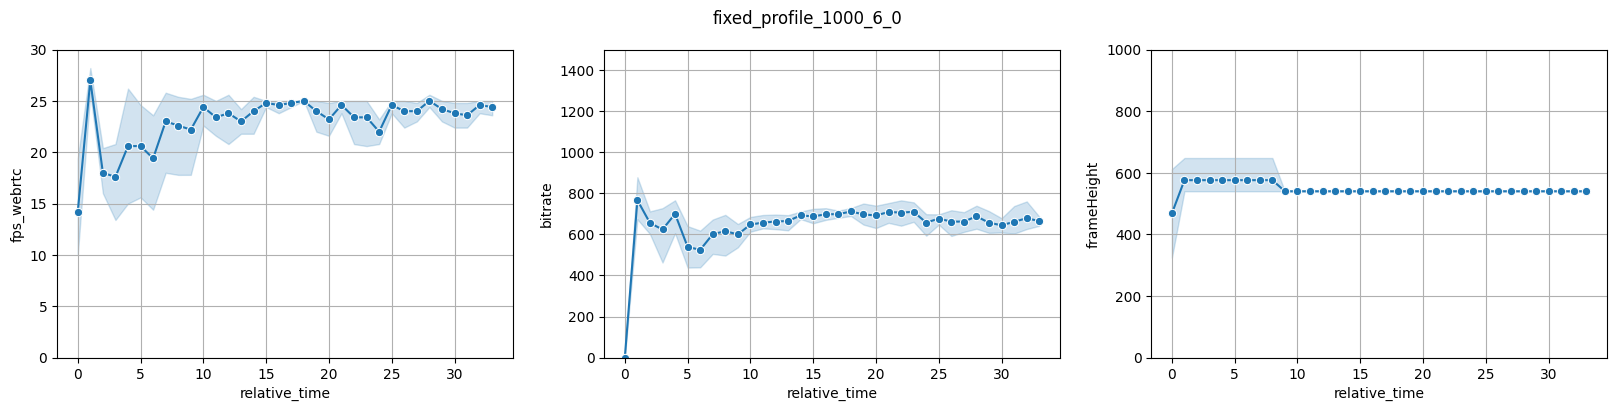

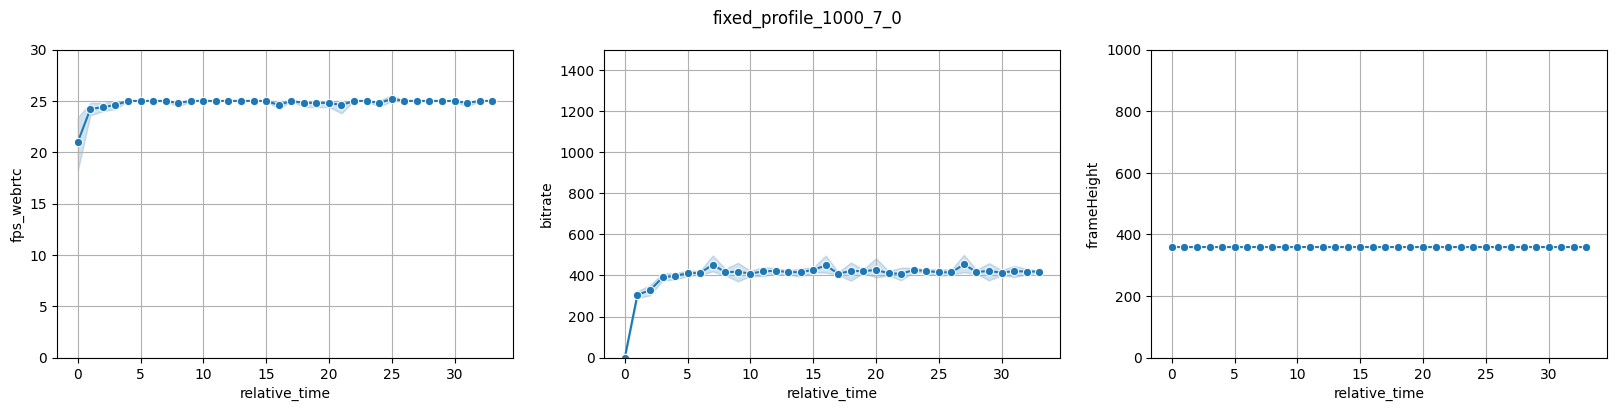

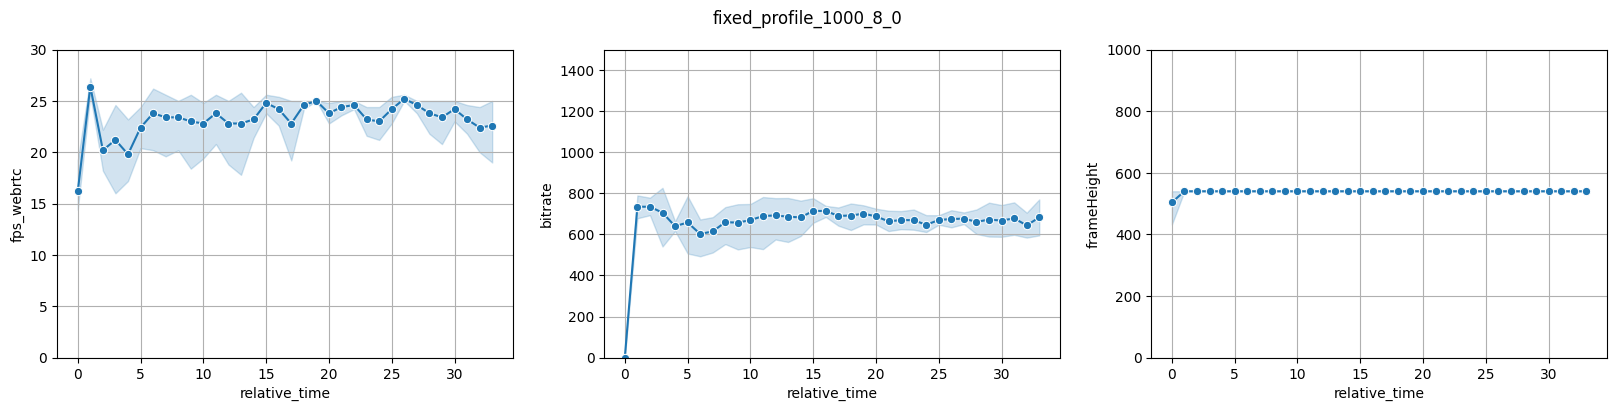

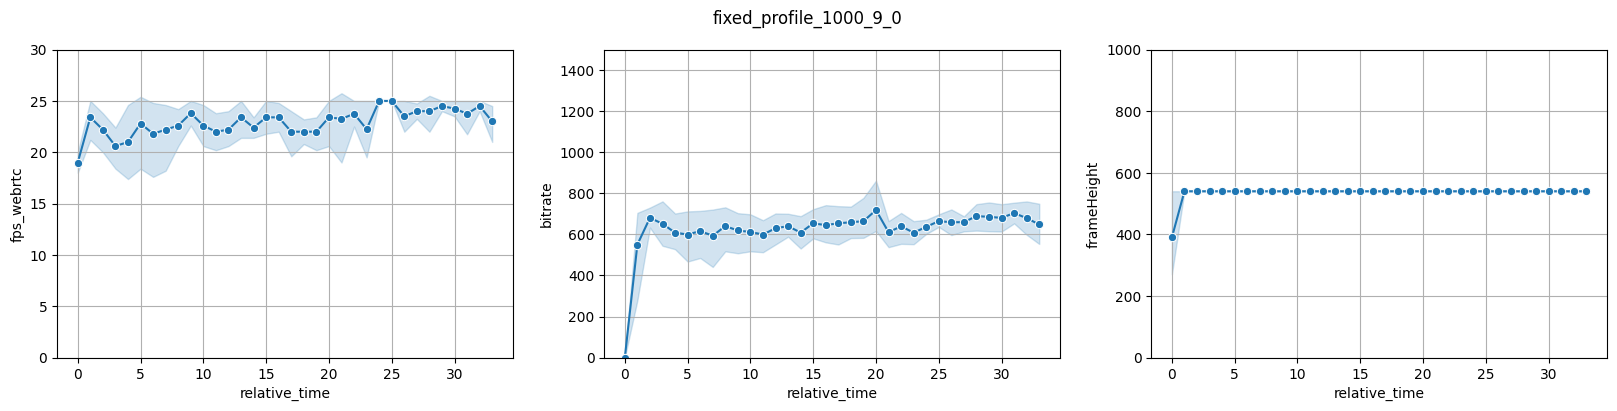

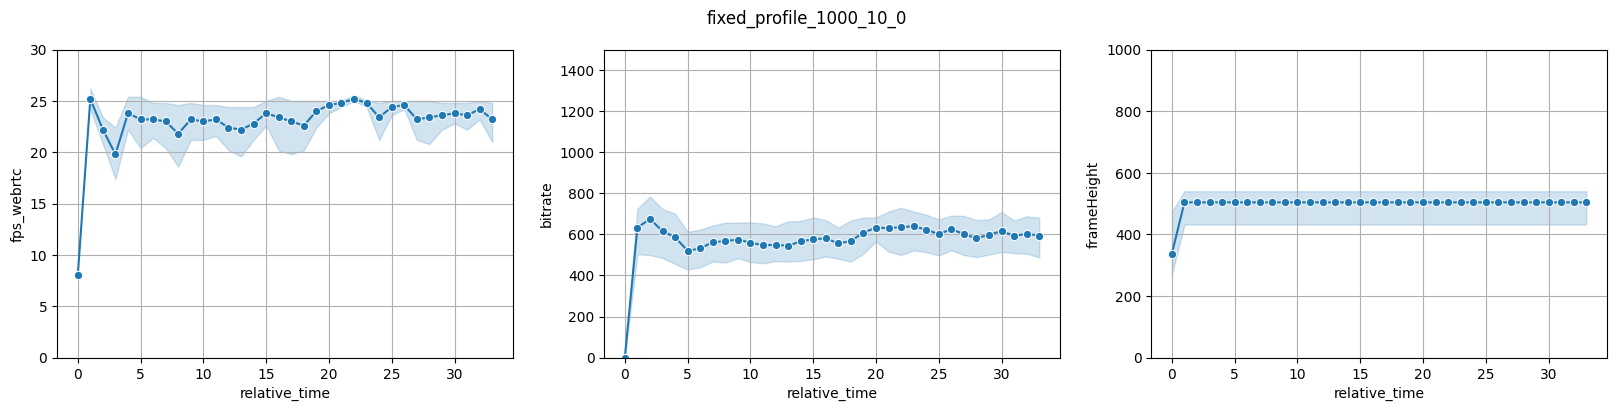

In [178]:
profiles = []
for i in range(11):
    profiles.append(f'fixed_profile_1000_{i}_0')
diagnose(df, profiles)

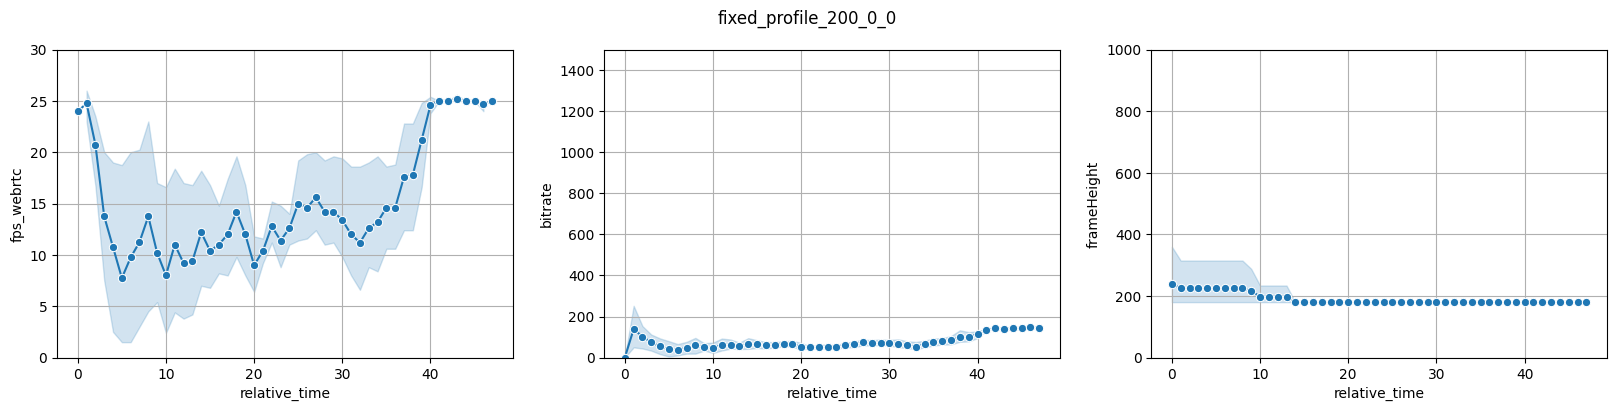

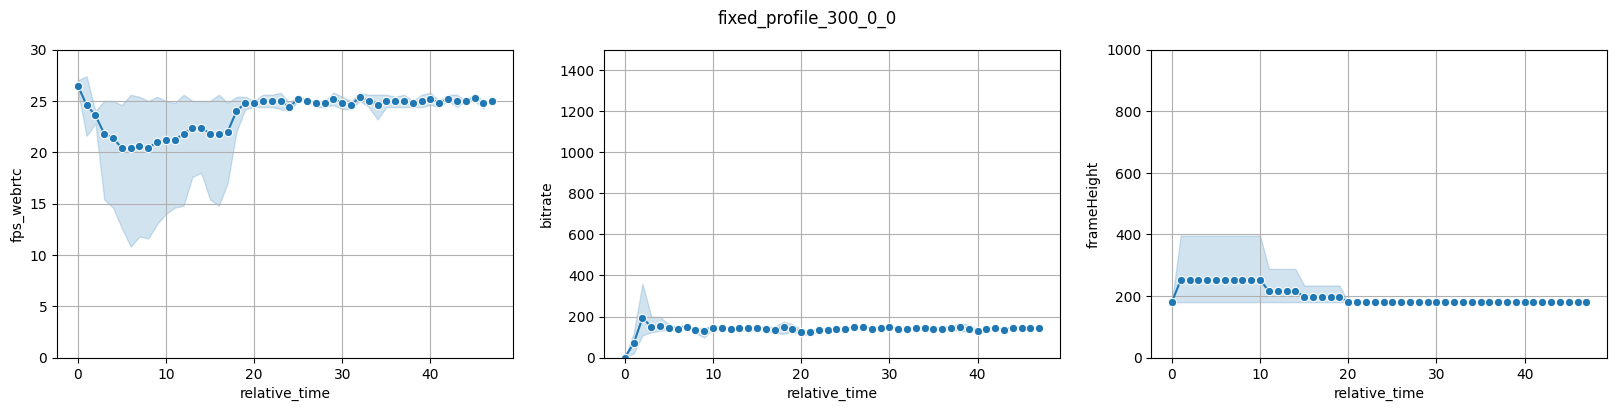

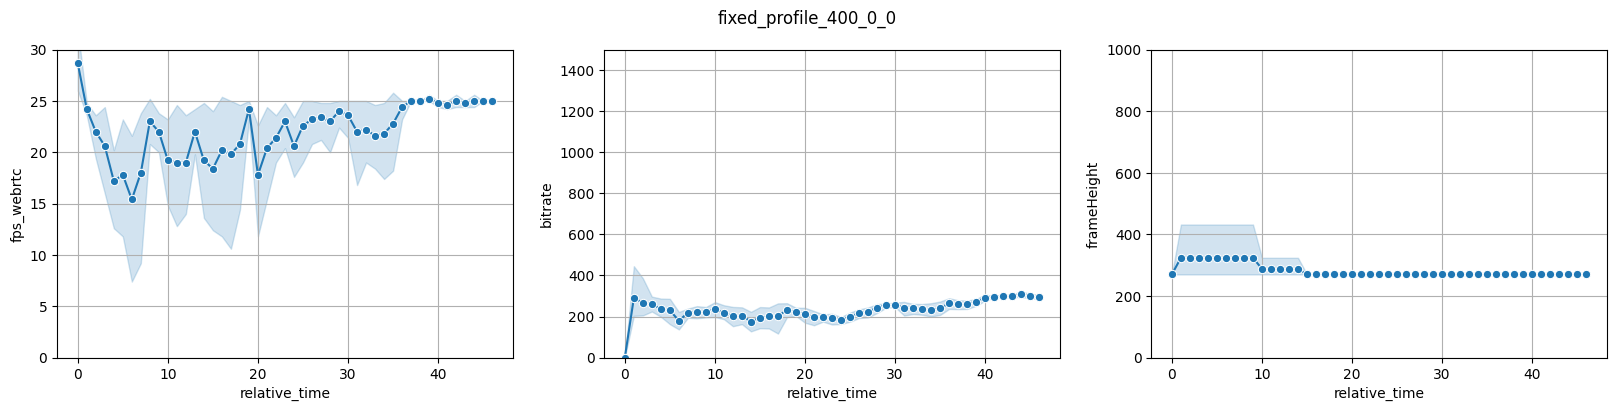

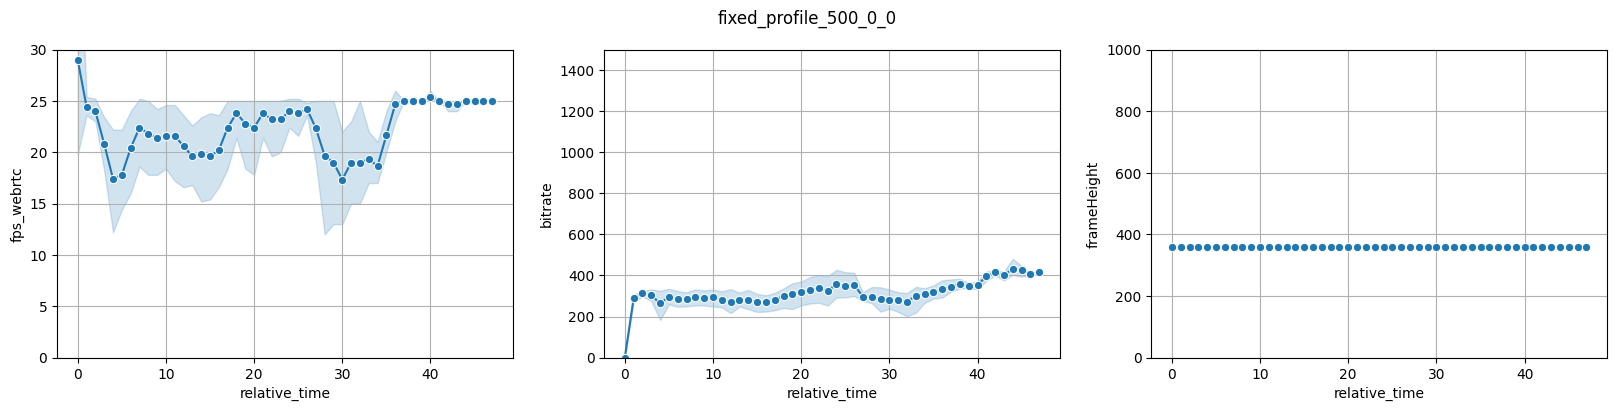

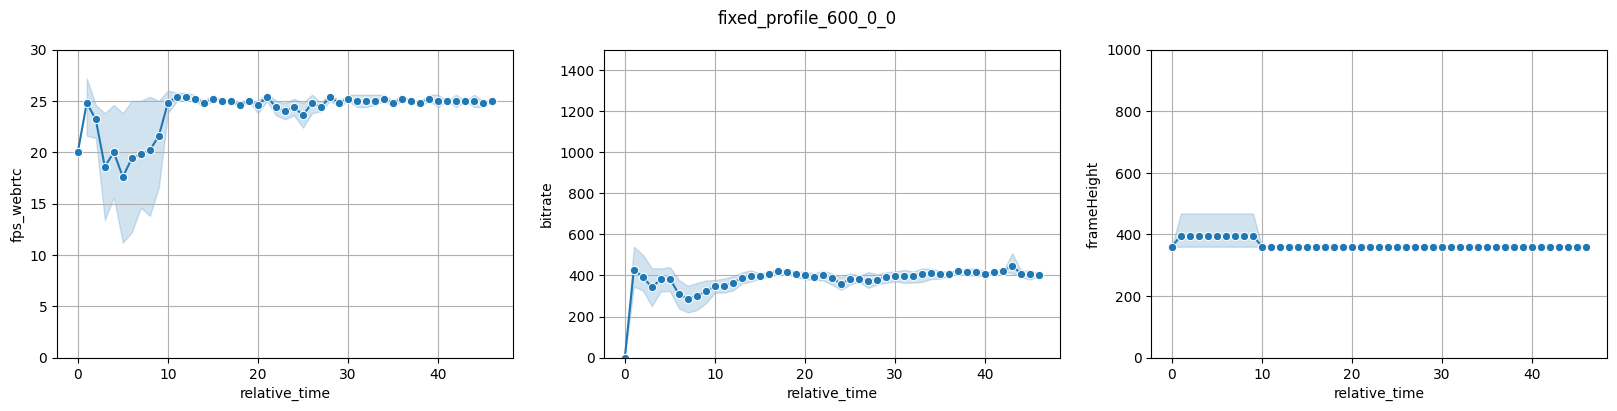

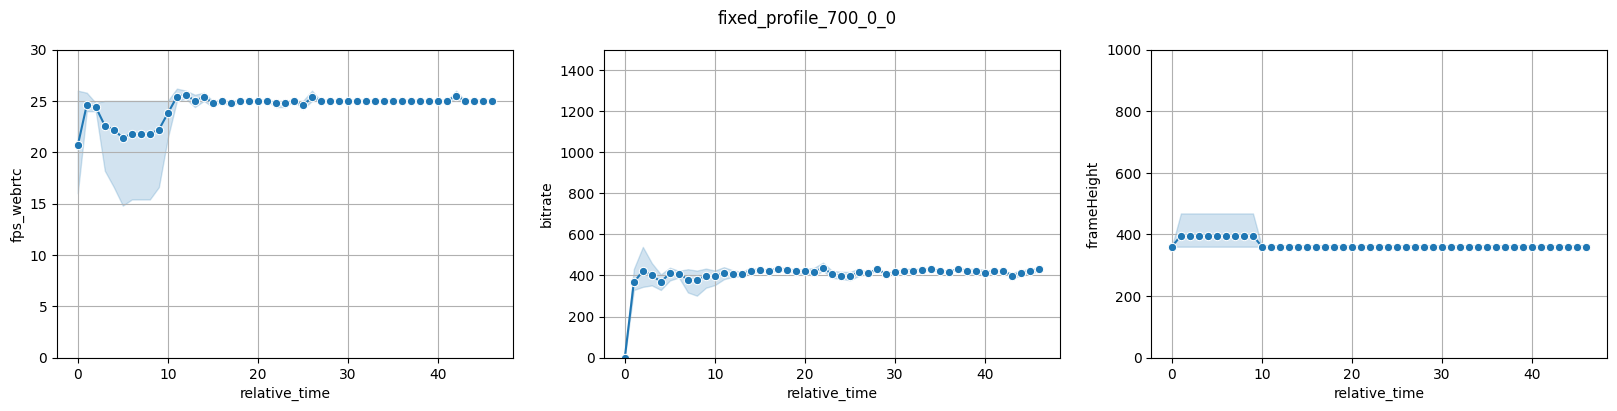

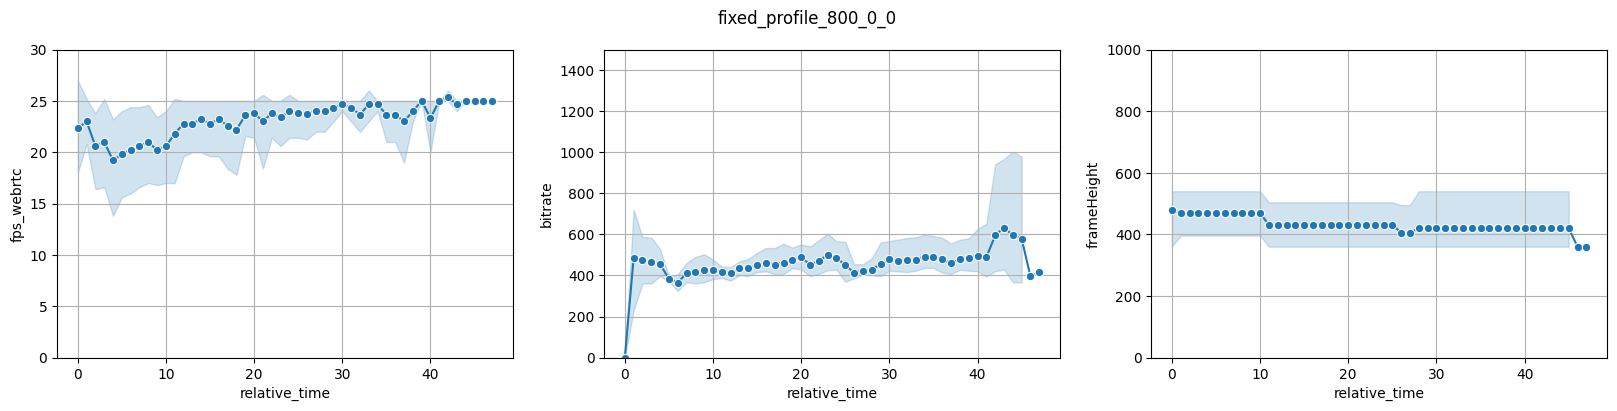

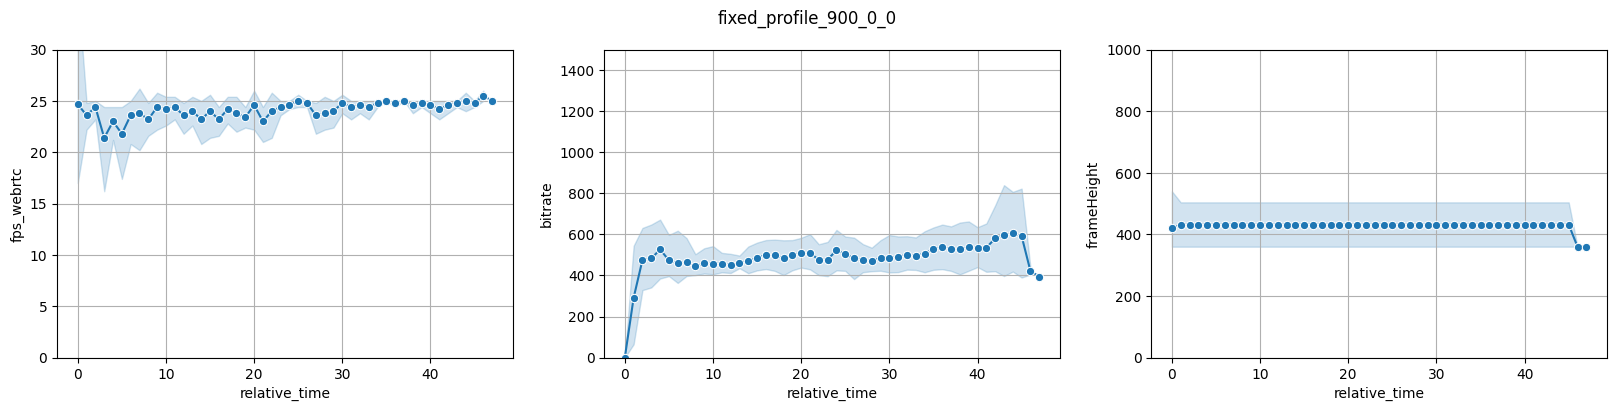

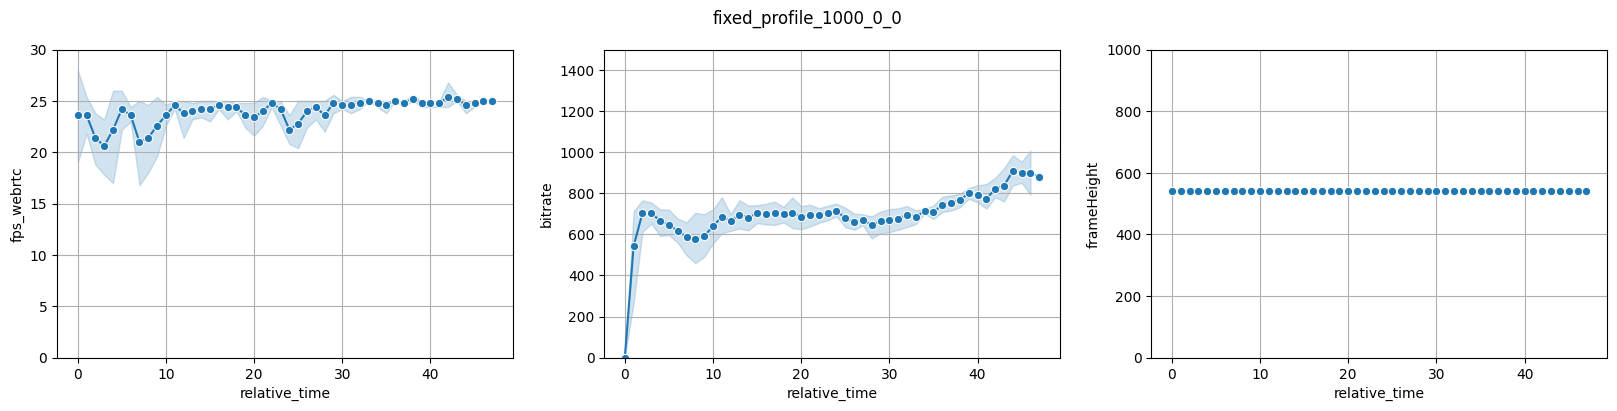

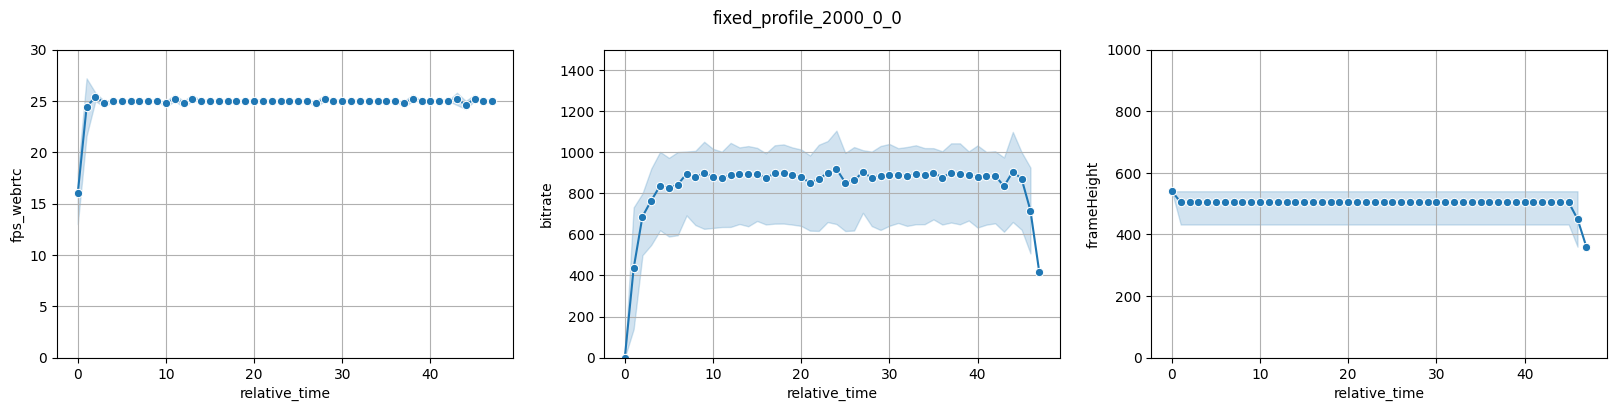

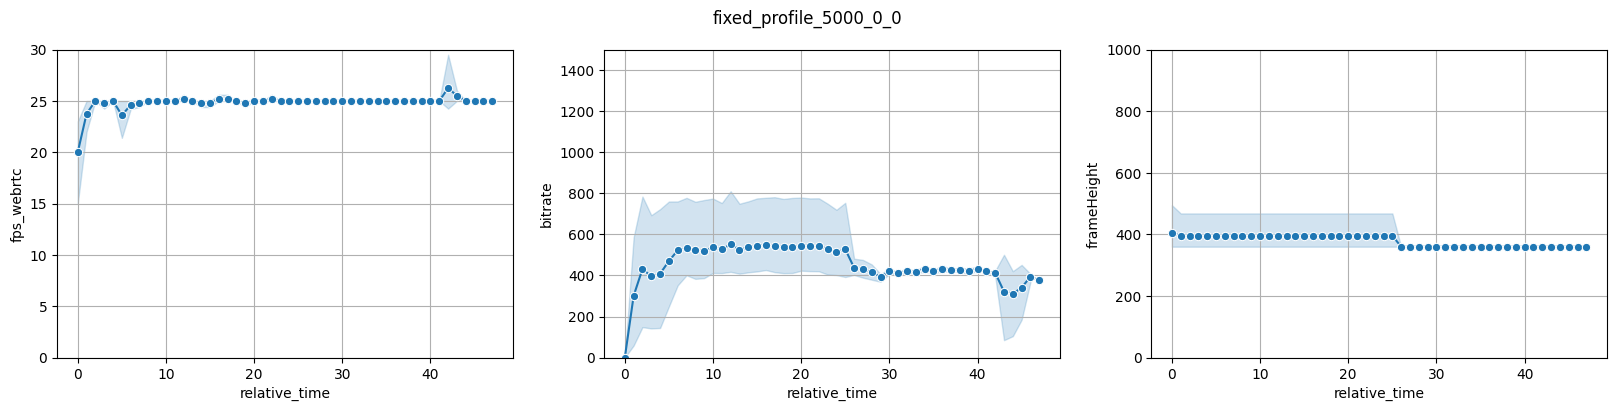

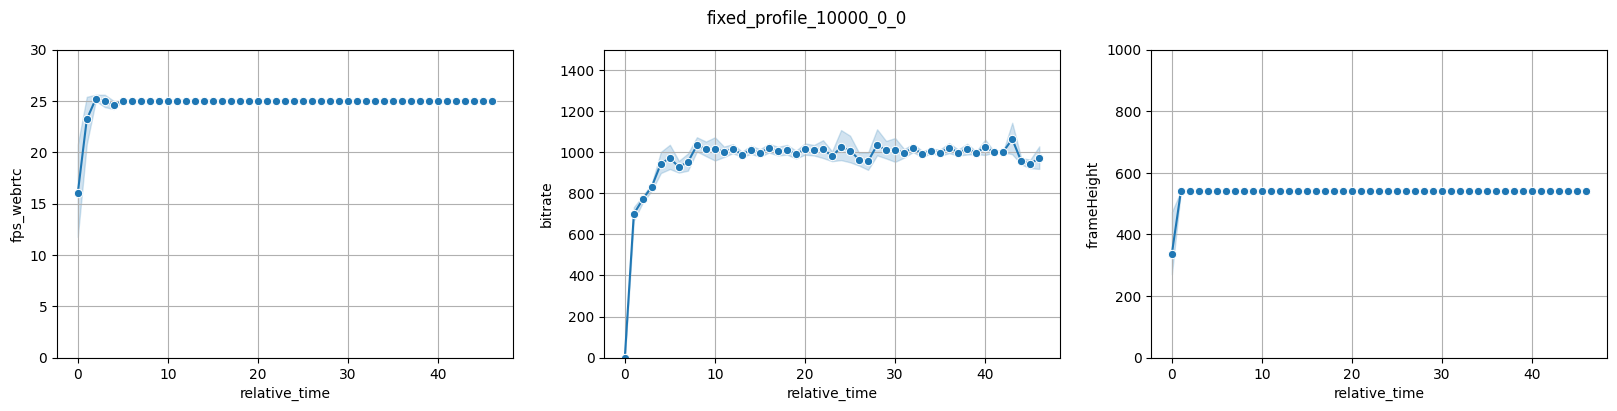

In [188]:
data_path = '../../data/Data_var_0_0'
data = []
for exp in os.listdir(data_path):
    for rep in os.listdir(data_path+'/'+exp):
        p = f'{data_path}/{exp}/{rep}'
        webrtc = os.listdir(f'{p}/meet/webrtc')[0]
        html5 = os.listdir(f'{p}/meet/html5')[0]
        webrtc = f'{p}/meet/webrtc/{webrtc}'
        html5 = f'{p}/meet/html5/{html5}'
        data.append((exp, rep, webrtc, html5))
df = combine(data)
vals = [x for x in range(200, 1001, 100)] + [2000, 5000, 10000]
names = [f'fixed_profile_{v}_0_0' for v in vals]
diagnose(df, names)

In [184]:
df

,fps_html_rendered,fps_html_dropped,html_ts,webrtc_ts,fps_webrtc,bitrate,frameHeight,exp,rep
0,8.0,0.0,1679859433,1.679859e+09,21.0,0.000000,360.0,fixed_profile_500_0_0,rep_1
1,25.0,0.0,1679859434,1.679859e+09,24.0,294.793092,360.0,fixed_profile_500_0_0,rep_1
2,23.0,0.0,1679859435,1.679859e+09,25.0,324.531298,360.0,fixed_profile_500_0_0,rep_1
3,19.0,0.0,1679859436,1.679859e+09,25.0,335.451158,360.0,fixed_profile_500_0_0,rep_1
4,23.0,0.0,1679859437,1.679859e+09,23.0,340.345903,360.0,fixed_profile_500_0_0,rep_1
...,...,...,...,...,...,...,...,...,...
119,25.0,0.0,1679867095,NaN,NaN,NaN,NaN,fixed_profile_10000_0_0,rep_4
120,25.0,0.0,1679867096,NaN,NaN,NaN,NaN,fixed_profile_10000_0_0,rep_4
121,25.0,0.0,1679867097,NaN,NaN,NaN,NaN,fixed_profile_10000_0_0,rep_4
122,25.0,0.0,1679867098,NaN,NaN,NaN,NaN,fixed_profile_10000_0_0,rep_4


In [4]:
%run '../util/webrtc_reader.py'

In [6]:
data_path = '/data/vca-qoe-inference/model_data/data/conext_data/logs_Meet_06-15_rush_hour/webrtc'
dfs = []
idx = 1
for f in os.listdir(data_path):
    df = WebRTCReader(f'{data_path}/{f}').get_webrtc()
    df['ts'] += 1
    dw = df.rename(columns={'ts': 'webrtc_ts', 'framesPerSecond': 'fps_webrtc', '[bytesReceived_in_bits/s]': 'bitrate'})
    dw['bitrate'] = dw['bitrate']/1000
    dw['file'] = f
    dw['index'] = idx
    dw = dw[['webrtc_ts', 'fps_webrtc', 'bitrate', 'duration', 'num_vals', 'file', 'index']]
    dfs.append(dw)
    idx += 1
df = pd.concat(dfs, axis=0)

In [13]:
dfd = df.groupby('file')[['duration', 'num_vals']].mean().reset_index()

In [14]:
dfd[(dfd['duration'] - dfd['num_vals'] > 5)]

,file,duration,num_vals
1,100_24_51583_2493_54_1655336144.json,57.005,49.0
151,239_51_350333_202901_50_1655341749.json,52.999,39.0
178,3148_180_84210_27100_34_1655335283.json,36.003,25.0
213,391_25_54991_13007_62_1655326010.json,63.998,37.0
218,4027_1683_113403_2685_30_1655320498.json,30.667,23.0
261,573_373_768895_692121_42_1655333263.json,43.999,26.0
